In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import scipy
from scipy import stats
from scipy.optimize import brentq, least_squares

# Option Smile Calibration using SABR Model

This notebook demonstrates the use of SABR Model to fit and calibrate implied volatility smile against observed market data.

In this example, the S&P 500 index options are used. The market data was extracted from WRDS, and the prices were based on 01/12/2020. Due to copyright, the data will not be uploaded onto the GitHub. 

Three expirations are used for this purpose:
- Front month contract: 20201218 Expiry
- Second month contract: 20210115 Expiry
- Third month contract: 20210219 Expiry

All options with valid bid- and offer prioces are included. The contract is an European option, which can only be exercised on the day of expiry and not earlier.

The US Zero curve is used as a proxy for the risk-free rate required in the Option Pricing Model.

## Recap: Black-Scholes Model and Implied Volatility

The Black-Scholes model was introduced back in 1973, when Black and Scholes published the model in their renown paper, "The Pricing of Options and Corporate Liabilities". Prior to the Black-Scholes model, there existed many option pricing models, some taking very similar form as the one introduced in the paper. What made the Black-Scholes model popular and more widely adopted is that the Black-Scholes model relied solely on market observable parameters. Unlike its predecessors, which made use of historical measure and attempted to estimate investors' expectation of the underlying price development, the Black-Scholes model takes a risk-neutral approach to pricing options, by replication. 

The Black-Scholes option pricing model is described in Eq. (1.1) (call) and Eq. (1.2) (put).

$$V_C = S_0\Phi(d_1) - Ke^{-r(T)}\Phi(d_2) \tag{1.1}$$

where
- $d_2 = \frac{ln(\frac{S_0}{K}) + (r - \frac{1}{2}\sigma^2)(T)}{\sigma \sqrt{T}}$
- $d_1 = \frac{ln(\frac{S_0}{K}) + (r + \frac{1}{2}\sigma^2)(T)}{\sigma \sqrt{T}} = d_2 + \sigma \sqrt{T}$
- $S_0$, $K$, $r$, $\sigma$, $T$ refer to the underlying spot price, strike price, zero rate, implied volatilty and time-to-expiry (in years) respectively
- $\Phi(\cdot)$ is a normal cumulative distribution function


In the case of a put option, the option pricing formula is:

$$V_P = Ke^{-r(T)}\Phi(-d_2) - S_0\Phi(-d_1) \tag{1.2}$$

As the name implies (haha), the implied volatility is a quantity that is derived from the market option price. It is commonly used in reporting or quoting prices as this quantity is more robust and less sensitive to changes in other parameters as opposed to the actual price. However, due to the structure of the Black-Scholes model, there is no closed form solution to solving for implied volatility. Numerical methods are required to work out an approximation of the implied volatility of the option.

In [2]:
def black_scholes_option_pricer(S, K, r, T, sigma, call = True):
    '''
    Function calculates option prices based on Black-scholes model.
    
    Inputs:
    S: underlying asset price at t; can be an array of prices
    K: strike price; can be an array of prices
    r: interest rate, annualized
    T: time to expiration (also the T-t in our equations), in number of years
    sigma: implied volatility of the option
    call: default True. True if pricing call options; otherwise False

    Outputs: Option Prices.
    '''

    d2 = (np.log(S/K) +(r - 0.5*np.square(sigma))*(T))/(sigma*np.sqrt(T))
    d1 = d2 + sigma*np.sqrt(T)
    
    if not call:
        d2 = -d2
        d1 = -d1

    option_values = S*scipy.stats.norm.cdf(d1) - K*np.exp(-r*T)*scipy.stats.norm.cdf(d2)
    option_values = option_values if call == True else -option_values

    return option_values

## Volatility skew and smile

When looking into implied volatility, one would start with the At-the-money (ATM) options. The ATM option is one whose strike price equals to the current underlying spot price, i.e. $K = S_0$. It is the common reference point for options.

When one derives the ATM implied volatility, and compare it with the other options, one may quickly discover that
1. If the same method is used to find the implied volatility of other contracts, all the implied volatilities are likely to be different (and can be drastically so), and
2. Using the ATM implied volatility may severely underprice the out-of-the-money (OTM) put options relative to the market observed prices.

This is because implied volatility is a reflection of price, and the price of an option is driven by market demand and supply forces. OTM put options yield higher implied volatilities due to the need for downside protection, where investors purchase put options to hedge against adverse downward price movements. Sometimes, when the market has high speculative activities, we may also find that the OTM call options have higher implied volatilities than the ATM call options. (This usually happens when the option is about to expire, or in emerging markets where speculations are more prominent)

If the volatility curve is downward sloping, we call this phenomenom a "volatility skew". If the curve exhibits a convex shape with OTM call and put implied volatilites being higher, this is what we called the "volatility smile".

---

## Data Extraction and Exploration

Since we are fitting the implied volatility smile of the S&P 500 index option, apart from loading the SPX option prices and the zero curve data, we need to extract the spot price of S&P 500 index on the date of interest.

Here, we are using the `yfinance` package, that scrapes the data from Yahoo finance.

In [3]:
# Load data
spx_prices = pd.read_csv('SPX_options.csv') # SPX Option market data
zero_rates = pd.read_csv('zero_rates_20201201.csv') # Zero curve data

In [4]:
spx_prices.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E
3,20201201,20201218,C,400000,3247.7,3270.6,E
4,20201201,20201218,C,500000,3147.7,3170.6,E


In [5]:
spx_prices.describe()

,date,exdate,strike_price,best_bid,best_offer
count,2072.0,2.072000e+03,2.072000e+03,2072.000000,2072.000000
mean,20201201.0,2.020661e+07,3.004778e+06,419.223238,423.744112
std,0.0,4.374636e+03,8.620634e+05,639.619427,644.621611
min,20201201.0,2.020122e+07,1.000000e+05,0.000000,0.050000
25%,20201201.0,2.020122e+07,2.550000e+06,5.175000,5.400000
50%,20201201.0,2.021012e+07,3.095000e+06,91.900000,92.850000
75%,20201201.0,2.021012e+07,3.591250e+06,635.075000,643.125000
max,20201201.0,2.021022e+07,5.400000e+06,3547.600000,3570.500000


We see that the dates (`date` and `exdate` columns) are floats in `%Y%m%d` format. This is something that we need to take note and use at the later part of our analysis.

The strikes appear to be too huge. The SPX price level should be in the order of thousands (`1e3`), whereas these go from `1e5` to `1e6`. It is likely that we need to scale down the strike price by a factor of 1000.

Lastly, looking at the `best_bid` column, we see that the minimum value is 0. We do not face the same issue with `best_offer`. A preliminary guess is that these contracts are far OTM or far ITM, that are so illiquid that there are missing quotes. These are contracts that we may not wish to include in our smile fit, as they being illiquid makes them not easily tradable, thus data points would not be representative of the true market implied volatility.

To ascertain our gues, we shall look into the rows where `best_bid` equals to 0. Before that, we need to do some data cleaning, and we may require getting the underlying spot price as well.

In [6]:
# Get the key dates
ex_dates = spx_prices.exdate.unique()
spot_date = spx_prices.date.unique()[0]

In [7]:
# Extract required spot price from yahoo finance API
query_start = datetime.strptime(str(spot_date), "%Y%m%d").strftime("%Y-%m-%d")
query_end = datetime.strptime(str(spot_date+1), "%Y%m%d").strftime("%Y-%m-%d")

spx_ticker = yf.Ticker("^GSPC")
spx_history = spx_ticker.history(start=query_start, end=query_end)
spx_spot = spx_history["Close"].values[-1]

print('The spot price of S&P 500 index on {} is ${:.2f}.'.format(query_start, spx_spot))

The spot price of S&P 500 index on 2020-12-01 is $3662.45.


In [8]:
def get_AOTM_options(x, spot):
    if x['cp_flag'] == 'C':
        return True if x['strike_price'] >= spot else False
    else:
        return True if x['strike_price'] <= spot else False

In [9]:
spx_prices['strike_price'] *= 0.001
spx_prices['AOTM'] = spx_prices.apply(lambda x: get_AOTM_options(x, spx_spot), axis = 1)
spx_prices.loc[(spx_prices['best_bid'] == 0)].head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,AOTM
400,20201201,20201218,C,4400.0,0.0,0.1,E,True
401,20201201,20201218,C,4500.0,0.0,0.1,E,True
402,20201201,20201218,C,4600.0,0.0,0.1,E,True
403,20201201,20201218,C,4700.0,0.0,0.1,E,True
404,20201201,20201218,C,4800.0,0.0,0.1,E,True


In [10]:
spx_prices.loc[(spx_prices['best_bid'] == 0)].AOTM.unique()

array([ True])

As observed in the above, the contracts with missing best_bid quotes are far out-of-the-money. We will omit these rows in our data set.

The next thing that we need to do is to get the respective zero rates to be used to calculate the implied volatility of the contracts. To get these rates, we need to:
1. Identify the days to expiry of the respective contracts in our data set
2. Retrieve the zero rates corresponding to the days to expiry

In [11]:
# Get days to expiry
spx_prices['days_to_expiry'] = (pd.to_datetime(spx_prices.exdate, format = '%Y%m%d')-\
                                pd.to_datetime(spx_prices.date, format = '%Y%m%d')).dt.days

print('The days to expiry of the contracts are', spx_prices['days_to_expiry'].unique())

The days to expiry of the contracts are [17 45 80]


In [12]:
zero_rates.head()

,date,days,rate
0,20201201,7,0.102280
1,20201201,13,0.114128
2,20201201,49,0.216480
3,20201201,77,0.220707
4,20201201,104,0.219996


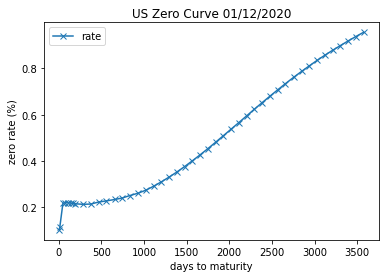

In [13]:
zero_rates.plot.line(x = 'days', y = 'rate', title = 'US Zero Curve 01/12/2020',\
                     xlabel = 'days to maturity', ylabel = 'zero rate (%)', marker = 'x')
plt.show()

As we observe, the required zero rates are for maturities in 17, 45 and 80 days, which are not part of the zero curve that we have. Here, we need to do some interpolations to get the required zero rates.

There are two options to doing so,
1. Interpolating the zero rates directly, and
2. Interpolating the discount factors and then derive the required zero rates.

It doesn't really matter for this case and both methods would work well, albeit the second method is more tedious and may seem unnecessary. The second method would be the best practice if we were to be dealing with interest rate derivatives. The advantage of interpolating the discount factors is that since discount factor $D(t,T)$ is a monotonically decreasing function w.r.t $T$, the noise introduced when interpolating is much smaller.

In this exercise, we shall explore the second method just to make the demonstration more rigourous.

In [14]:
# Derive discount factors from given zero rates
zero_rates['discount_factors'] = zero_rates.apply(lambda x: np.exp(-x['rate']/100*x['days']/365), axis = 1)

# Attempt to interpolate discount factors for the days to maturity of concern
xp = zero_rates['days'].to_numpy()
fp = zero_rates['discount_factors'].to_numpy()
days_to_expiry = np.array([(pd.Timestamp(str(ex_date)) - pd.Timestamp(str(spot_date))).days for ex_date in ex_dates])
required_discount_factors = np.interp(days_to_expiry, xp, fp)

# Derive requried zero rates from discount factors
required_zero_rates = -np.log(required_discount_factors)/(days_to_expiry/365)

# Packages days-to-expiry (key) and required zero rates (value) into a dictionary
r_dict = dict(zip(days_to_expiry, required_zero_rates))

# Print out the zero rate given days to expiry
print('The zero rates are as follows:')
for key, value in r_dict.items():
    print("{} days: {:.4f}%".format(key, value*100))

The zero rates are as follows:
17 days: 0.1469%
45 days: 0.2132%
80 days: 0.2206%


Now we have all the data that is required, it is time to prepare for the implied volatility calculation.

Referring to Eq. (1.1) and Eq. (1.2), we need to obtain the option value $V$, the time-to-expiry (in years) $T$, the zero rate $r$, and the underlying spot price $S$. 

To derive $V$, we shall use the market mid price, i.e. the average of the `best_bid` and `best_offer`. This is also the reason why we want to omit data points with no valid `best_bid`.

Next, we are only interested in ATM and OTM contracts. These contracts are more important as they are cheaper and likely more liquid (i.e. traded more oftenly) than their ITM counterparts. For the call options, we are looking at contracts with strike prices greater than the spot. Conversely, we will be looking at put contracts with strike prices below the spot.

Forward price calculation, though not necessary at this moment, will be required in the next step. More shall be explained later.

In [15]:
# Omit data points with 0 best_bid
spx_prices = spx_prices.loc[(spx_prices['best_bid'] != 0)]

# Get only ATM and OTM contracts
spx_prices = spx_prices[spx_prices['AOTM'] == True]
spx_prices = spx_prices.sort_values(by = 'strike_price')

# Get mid prices
spx_prices['mid'] = 0.5*(spx_prices['best_bid'] + spx_prices['best_offer'])

# Calculate required variables for implied vol calculation
spx_prices['T'] = spx_prices['days_to_expiry'] / 365
spx_prices['r'] = spx_prices['days_to_expiry'].apply(lambda x: r_dict[x])
spx_prices['F'] = spx_spot * np.exp(spx_prices['r'] * spx_prices['T'])

To calculate the implied volatility, we will be using the `brentq` optimizer from the scipy library. This optimizer is an implementation of the Brent's method, which is a root finding algorithm using a bracketing interval.

Our objective (function) is to minimize the difference between the market observed price and the theoretical price derived the Black-Scholes model. The parameter (root) to solve is the implied volatilty.

In [16]:
def get_implied_volatility(S, option_params):
    # unpack options_params
    payoff = option_params['cp_flag']
    K = option_params['strike_price']
    price = option_params['mid']
    r = option_params['r']
    T = option_params['T']
    
    try:
        if payoff == 'C':
            implied_vol = brentq(lambda x: price - black_scholes_option_pricer(S, K, r, T, x),
                                1e-12, 10.0)
        elif payoff == 'P':
            implied_vol = brentq(lambda x: price - black_scholes_option_pricer(S, K, r, T, x,call = False),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized: ', payoff)
    except:
        implied_vol = np.nan
        
    return implied_vol

In [17]:
spx_prices['implied_vol'] = spx_prices.apply(lambda x: get_implied_volatility(spx_spot, x), axis = 1)
spx_prices.dropna(inplace=True)
spx_prices_cleaned = spx_prices[['exdate', 'mid', 'cp_flag','strike_price', 'implied_vol', 'F', 'r', 'T']].copy()

In [18]:
spx_prices_cleaned.head()

,exdate,mid,cp_flag,strike_price,implied_vol,F,r,T
1824,20210219,0.125,P,900.0,0.926749,3664.221229,0.002206,0.219178
1825,20210219,0.200,P,1000.0,0.891176,3664.221229,0.002206,0.219178
1826,20210219,0.275,P,1100.0,0.849821,3664.221229,0.002206,0.219178
1827,20210219,0.350,P,1200.0,0.807115,3664.221229,0.002206,0.219178
1828,20210219,0.450,P,1300.0,0.768691,3664.221229,0.002206,0.219178


Now we are ready to implement the SABR calibration.

---

## SABR Model

The Stochastic Alpha-Beta-Rho (SABR) Model is a stochastic volatility model that was introduced by Patrick Hagan in 2002. It is expressed by a system of stochastic differential equation as shown in Eq. (2).

$$
\begin{cases}
    dF_t = \alpha_t F_t^\beta dW_t^F\\
    d\alpha_t = \nu \alpha_t dW_t^\alpha \\
\end{cases} \tag{2}
$$

where <br>
$F_t$: Underlying forward price<br>
$W_t^F$: The brownian motion used to describe the randomness in the underlying forward price, under the T-forward measure<br>
$\alpha_t$: The time varying stochastic volatility<br>
$W_t^\alpha$: The brownian motion used to describe the randomness in the volatility, under the T-forward measure<br>
$dW_t^F dW_t^\alpha = \rho dt$<br>
$\nu$: volatility of volatility, <i>vol-of-vol</i><br>

The stochastic volatility $\alpha_t$ follows a geometric brownian motion dynamic, and the underlying forward price follows a constant elasticity of variance (CEV) model under the T-forward measure.

## Obtaining market-fitted implied volatility using SABR Model

A typical calibration exercise entails the following steps
1. Define the desired option pricing model
2. With the known variables and an initial guess of the model parameters, compute the option prices and implied volatilities
3. Compare the computed option prices and implied volatilities with market prices and implied volatilities
4. Update the model parameters using selected optimization algorithm to minimize the loss function
5. Repeat steps 2 to 4 with the new guesses until the model is optimized to achieve below a maximum tolerable error

Step 2 of the calibration tends to be the most intensive computationally. The SABR Model helps to speed up the process as it introduces an approximated closed form solution of the Black-schole implied volatility derived from the model parameters, which can be used directly to compare with the market observed implied volatilities. The closed form solution is expressed as Eq. (3).

$$
\sigma_{SABR}(F_0, K, \alpha, \beta, \rho, \nu) = \frac{\alpha}{(F_0K)^{(1-\beta)/2}\{1 + \frac{(1-\beta)^2}{24}log^2(\frac{F_0}{K})+\frac{(1-\beta)^4}{1920}log^4(\frac{F_0}{K})+\cdots\}} \times \frac{z}{x(z)}\times \bigg\{1 + \bigg[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho \beta \nu \alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\bigg]T + \cdots \bigg\} \tag{3}
$$

where <br>
$z = \frac{\nu}{\alpha}(F_0K)^{(1-\beta)/2}log(\frac{F_0}{K})$<br>
$x(z) = log\bigg[\frac{\sqrt{1 - 2\rho z + z^2}+z - \rho}{1 - \rho}\bigg]$

Unlike the earlier optimization problem to solve for the implied volatility, SABR calibration that seeks to reduce the difference between the market-observed implied volatility and SABR 'Black-Schole' implied volatility requires tuning of more than one parameter. In fact, here we are tuning 5 different variables, namely $\alpha$, $\beta$, $\rho$ and $\nu$. Thus, root solving algorithms such as the Brent's method would not be useful. Instead, we shall use the Least Squares method, by utilising the ```least_squares``` optimizer from the ```scipy``` package. The loss function to minimize is a scaled sum of squares, as shown in Eq. (4).

$$\text{Cost} = \frac{1}{2}\sum^N_i((y_i - \hat{y}_i)^2) \tag{4}$$

In [19]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    
    z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
    zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
    numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
    numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
    numer3 = ((2 - 3*rho*rho)/24)*nu*nu
    numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
    denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
    denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
    denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
    sabrsigma = numer/denom

    return sabrsigma

In [20]:
def sabrcalibration(x, beta, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes.iloc[i], T,
                           x[0], beta, x[1], x[2]))**2
    
    return err

In [21]:
def plotter(df, SABR_vols, exdate, underlying):
    plt.figure(figsize = (8,4))

    plt.plot(df['strike_price'], df['implied_vol'], 'gs', label='Market Vols')
    plt.plot(df['strike_price'], SABR_vols, 'm--', label='SABR Vols')

    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.title("Implied volatility Smile of {0} options (expiring {1})".format(underlying, exdate))
    plt.legend()
    
    plt.show()

Now calibrate market prices for expiry = 20201218...


C:\Users\leeca\anaconda3\envs\finsinyur\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


Calibrated SABR model parameters: alpha = 1.898, beta = 0.7, rho = -0.520, nu = 4.210
The cost of the optimization (half of sum of squares), C =  5.382549451823796e-05
Plotting...


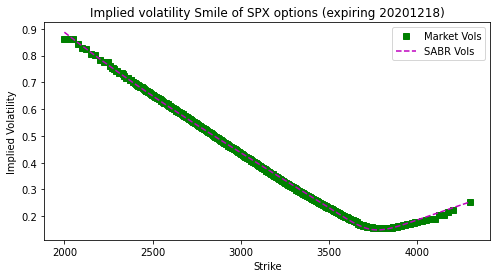

Now calibrate market prices for expiry = 20210115...
Calibrated SABR model parameters: alpha = 2.137, beta = 0.7, rho = -0.601, nu = 2.266
The cost of the optimization (half of sum of squares), C =  4.769967772820734e-06
Plotting...


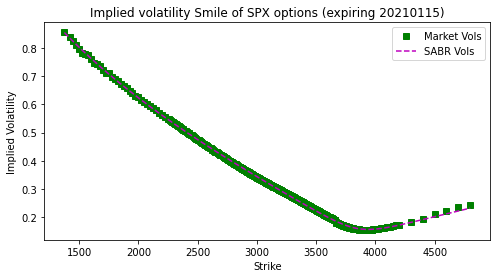

Now calibrate market prices for expiry = 20210219...
Calibrated SABR model parameters: alpha = 2.214, beta = 0.7, rho = -0.614, nu = 1.744
The cost of the optimization (half of sum of squares), C =  2.148890098821746e-05
Plotting...


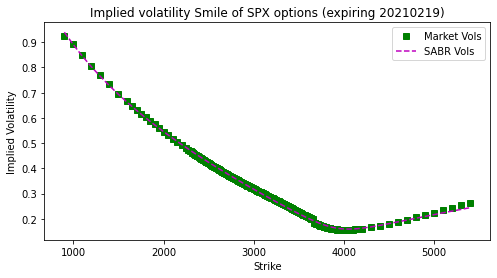

In [22]:
SABR_calibration = []

for ex_date in ex_dates:
    print('Now calibrate market prices for expiry = {}...'.format(ex_date))
    res_dict = {'Expiry': ex_date}
    
    df_to_calibrate = spx_prices_cleaned.loc[spx_prices_cleaned['exdate'] == ex_date].copy()
    
    F = df_to_calibrate['F'].unique()[0]
    r = df_to_calibrate['r'].unique()[0]
    T = df_to_calibrate['T'].unique()[0]
    
    SABR_beta = 0.7

    SABR_guess_0 = [0.02, 0.2, 0.1]
    SABR_res = least_squares(lambda x: sabrcalibration(x,
                                                       SABR_beta,
                                                       df_to_calibrate['strike_price'],
                                                       df_to_calibrate['implied_vol'],
                                                       F,
                                                       T
                                                      ),
                             SABR_guess_0)
    
    SABR_alpha = SABR_res.x[0]
    SABR_rho = SABR_res.x[1]
    SABR_nu = SABR_res.x[2]

    print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (SABR_alpha,
                                                                                                  SABR_beta,
                                                                                                  SABR_rho,
                                                                                                  SABR_nu))
    print('The cost of the optimization (half of sum of squares), C = ',  SABR_res.cost)
    
    SABR_vols = []
    
    for K in df_to_calibrate['strike_price']:
        SABR_vols.append(SABR(F, K, T, SABR_alpha, SABR_beta, SABR_rho, SABR_nu))
        
    print('Plotting...')
    plotter(df_to_calibrate,\
            SABR_vols,\
            ex_date,\
            'SPX')
    
    res_dict['alpha'] = SABR_alpha
    res_dict['beta'] = SABR_beta
    res_dict['rho'] = SABR_rho
    res_dict['nu'] = SABR_nu
    
    SABR_calibration .append(res_dict)

In [23]:
df_SABR = pd.DataFrame(SABR_calibration)
df_SABR.set_index('Expiry', inplace=True)
df_SABR

,alpha,beta,rho,nu
Expiry,,,,
20201218,1.898361,0.7,-0.520330,4.209630
20210115,2.137322,0.7,-0.600960,2.266466
20210219,2.213775,0.7,-0.614007,1.744331


The model is able to fit the volatility of the different expiries well. Now, we shall look into the effect of each parameter in the SABR model to the fitted volatility smile.

---

# Analysis: Impact of SABR Parameters to the fitted implied volatility smile

In this section, we shall analyze the effect of each parameter of the SABR model on the fitted volatility smile. As seen earlier, the SABR model has been rather successful in fitting the smile. The smile can be broken down into the level (the position of the curve along the y-axis), the slope and the curvature. In order to fit these three dimension, the model needs at least three degrees of freedom. Each of these parameters represents at least one of these three degrees of freedom.

Recall from Eq. (2) that
- $\alpha$ is the initial volatility of the stochastic volatility model; it controls the level of the curve
- $\beta$ is the CEV model parameter; it controls the skew of the curve
- $\rho$ is the correlation between the forward price dynamic and the volatility dynamics; it controls the skew of the curve
- $\nu$ is the vol of vol, it controls the curvature of the curve

In [24]:
strikes = np.arange(1000, 5000, 100)
alpha_0, beta_0, rho_0, nu_0 =  df_SABR.loc[20201218]
spx_forward = spx_prices_cleaned.loc[spx_prices_cleaned['exdate'] == 20201218, 'F'].unique()[0]
T = spx_prices_cleaned.loc[spx_prices_cleaned['exdate'] == 20201218, 'T'].unique()[0]

ls_alpha = []
ls_beta = []
ls_rho = []
ls_nu = []

for delta in np.arange(-0.5, 0.75, 0.25):
    res_alpha = SABR(spx_forward, strikes, T, alpha_0*(1+delta), beta_0, rho_0, nu_0)
    ls_alpha.append(res_alpha)
    
    res_beta = SABR(spx_forward, strikes, T, alpha_0, beta_0*(1+delta), rho_0, nu_0)
    ls_beta.append(res_beta)
    
    res_rho = SABR(spx_forward, strikes, T, alpha_0, beta_0, rho_0*(2*delta), nu_0)
    ls_rho.append(res_rho)
    
    res_nu = SABR(spx_forward, strikes, T, alpha_0, beta_0, rho_0, nu_0*(1+delta))
    ls_nu.append(res_nu)


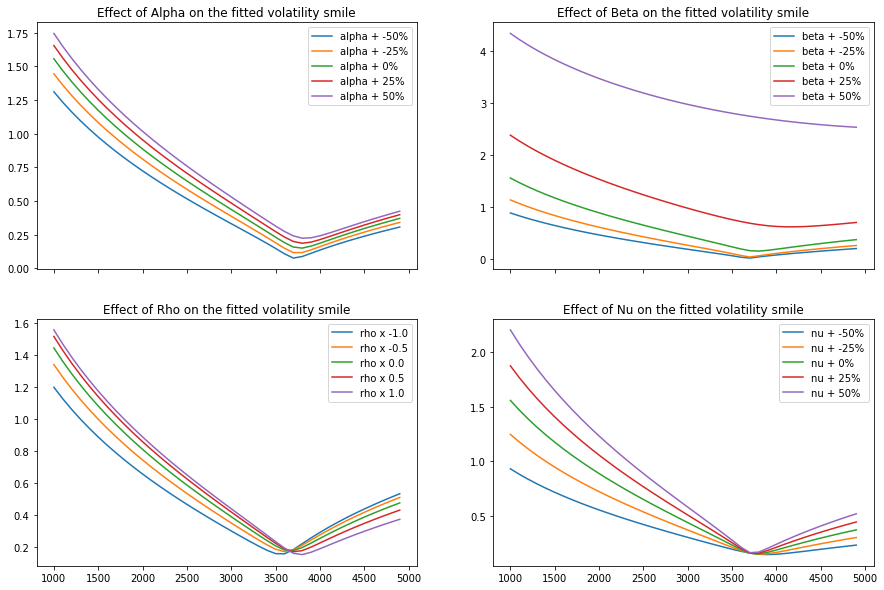

In [25]:
f, ax = plt.subplots(2,2,figsize=(15,10), sharex = True)

ax[0,0].title.set_text('Effect of Alpha on the fitted volatility smile')
for arr, delta in zip(ls_alpha, np.arange(-0.5, 0.75, 0.25)):
    ax[0,0].plot(strikes, arr, label = 'alpha_0 + {:.0f}%'.format(delta * 100))
ax[0,0].legend()

ax[0,1].title.set_text('Effect of Beta on the fitted volatility smile')
for arr, delta in zip(ls_beta, np.arange(-0.5, 0.75, 0.25)):
    ax[0,1].plot(strikes, arr, label = 'beta_0 + {:.0f}%'.format(delta * 100))
ax[0,1].legend()

ax[1,0].title.set_text('Effect of Rho on the fitted volatility smile')
for arr, delta in zip(ls_rho, np.arange(-0.5, 0.75, 0.25)):
    ax[1,0].plot(strikes, arr, label = 'rho_0 x {:.1f}'.format(delta * 2))
ax[1,0].legend()

ax[1,1].title.set_text('Effect of Nu on the fitted volatility smile')
for arr, delta in zip(ls_nu, np.arange(-0.5, 0.75, 0.25)):
    ax[1,1].plot(strikes, arr, label = 'nu_0 + {:.0f}%'.format(delta * 100))
ax[1,1].legend()

plt.show()

From the above charts, we noticed the following.<br>

<b>Initial volatility, $\alpha$</b><br>
- the greater the $\alpha$, the higher the level of the curve is
- changing $\alpha$ produces a verticle shift in the curve
- the minima of the curve is also shifted rightwards with increasing $\alpha$

<b>CEV parameter, $\beta$</b><br>
- $\beta$ appears to impact both the level and the skew of the curve
- $\beta$ controls the relationship between volatility and price
- if $\beta < 1$, volatility increases with decreased price; this is also known as the "leverage effect", which is common in equity market
- conversely, if $\beta > 1$, volatility increases with increased price; this is more prominent in the commodity market
- Because $\beta$ controls two degree of freedom at once, we do not calibrate $\beta$ in our exercise and we simply leave it as 0.7

<b>Correlation, $\rho$</b><br>
- $\rho$ describes the correlation between volatility and price
- skewness increases as $\rho$ decreases - note: in our chart, $\rho_0$ is negative

<b>Vol-of-Vol, $\nu$</b><br>
- the higher the vol-of-vol, the more curved the smile is
- OTM implied volatility increases while ATM ivol remained the same level
- the higher the vol-of-vol, the more likely OTM contracts would expire ITM
- therefore, contracts would be priced higher, yielding higher implied volatility.

---

# References

Hagan, P. S., Kumar, D., Lesniewski, A. S., & Woodward, D. E. (2002). Managing smile risk. Wilmott Magazine, Volume(1), 84-108.

Black, F., & Scholes, M. (1973). The Pricing of Options and Corporate Liabilities. Journal of Political Economy, Volume(81), 637-654.